# benchmark.ipynb

This notebook contains the text and code for the next blog post in the zero-copy model series, 
title TBD.

The first post explained how to load PyTorch models for inference extremely fast by leveraging the Plasma object store's ability to load numeric data directly from shared memory.

In this post, we talk in more concrete terms about how to use this zero-copy model loading for model serving. We put together a simple model serving system, then set up a microbenchmark that simulates a heavy-tailed traffic pattern.

In [1]:
# Initialization and import code goes in this cell.

# Imports: Python core, then third-party, then local.
# Try to keep each block in alphabetical order, or the linter may get angry.

import asyncio
import concurrent.futures
import requests
import starlette
import time
import os
import json

from typing import Dict, Callable, Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ray
from ray import serve
import torch
import transformers

import zerocopy

# Fix silly warning messages about parallel tokenizers
os.environ['TOKENIZERS_PARALLELISM'] = 'False'


# Reduce the volume of warning messages from `transformers`
transformers.logging.set_verbosity_error()


def reboot_ray():
    if ray.is_initialized():
        ray.shutdown()

    if torch.cuda.is_available():
        return ray.init(num_gpus=1)
    else:
        return ray.init()

# Title of new blog post goes here

*Recap of previous blog post goes here.*

In a [previous post](https://medium.com/ibm-data-ai/how-to-load-pytorch-models-340-times-faster-with-ray-8be751a6944c), we introduced the concept of *zero-copy model loading*. Zero-copy model loading involves keeping the weights of a deep learning model in shared memory, so that different processes can "load" the model for inference without needing to have a copy of the weights in their local heap memory.

We showed that the Plasma object store integrated into Ray makes it easy to do zero-copy model loading, and that that implementing this technique on Ray can accelerate model loading by several orders of magnitude. If you'd like to find out more about the details of zero-copy model loading, follow [this link](https://medium.com/ibm-data-ai/how-to-load-pytorch-models-340-times-faster-with-ray-8be751a6944c) to view the previous post.

In this post, we focus on how to use zero-copy model loading for production deployments of large natural language processing (NLP) models. We introduce `zerocopy`, a Python package that makes it extra simple to apply zero-copy model loading to PyTorch models. We show how easy it is to deploy modern NLP models using with `zerocopy` and Ray Serve. Finally, we present an end-to-end model serving benchmark that shows how we can serve 12 state-of-the-art NLP models with a single cloud VM and achieve (**TODO: final numbers**)x better scalability.

In [2]:
# Don't include this cell in the blog post.
# Fire up Ray
serve.shutdown()
reboot_ray()
serve.start()

# Wait a moment to make sure that all log output goes to this cell
time.sleep(1.)

2022-03-04 15:57:26,911	INFO services.py:1374 -- View the Ray dashboard at http://127.0.0.1:8265
(ServeController pid=16252) 2022-03-04 15:57:31,076	INFO checkpoint_path.py:16 -- Using RayInternalKVStore for controller checkpoint and recovery.
(ServeController pid=16252) 2022-03-04 15:57:31,186	INFO http_state.py:98 -- Starting HTTP proxy with name 'SERVE_CONTROLLER_ACTOR:XTDcTe:SERVE_PROXY_ACTOR-node:127.0.0.1-0' on node 'node:127.0.0.1-0' listening on '127.0.0.1:8000'
2022-03-04 15:57:31,596	INFO api.py:475 -- Started Serve instance in namespace 'dac37c52-87e4-4e60-a461-5d85c99250dc'.
(HTTPProxyActor pid=16251) INFO:     Started server process [16251]


## Introducing `zerocopy`

Our previous post included code snippets that show how to rewrite a PyTorch model to use zero-copy model loading. 
We've recently created a Python package, `zerocopy`, that lets you apply this technique to your models without having to copy and paste a bunch of Python code. 

**TODO: Explain the relationship between `zerocopy` and Project Codeflare**

**(TODO: Publish the package to PyPI and insert installation instructions here)**

Using the `zerocopy` package is a three-step process:
1. Import the package
2. Move your model's weights onto the Plasma object store
3. Run your model in an asynchronous Ray task

Let's show these three steps in action with the [BERT language model](https://arxiv.org/abs/1810.04805) as implemented in the [Transformers](https://huggingface.co/docs/transformers/index) library.

Step 1 is just a Python `import` statement:
```python 
import zerocopy
```

Then it's on to step 2: Moving your model's weights onto Plasma. You will of course need a PyTorch model to do this step. Here we use the Transformers library's `from_pretrained()` function to load a copy of BERT.

In [3]:
bert_model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [4]:
# Don't include this cell in the blog
# Load a tokenizer to go with the model
bert_tokenizer = transformers.BertTokenizer.from_pretrained(
    'bert-base-uncased')
text = "What's another word for 'thesaurus'?"
bert_input = bert_tokenizer(text, return_tensors='pt')
bert_input

{'input_ids': tensor([[  101,  2054,  1005,  1055,  2178,  2773,  2005,  1005,  1996, 22244,
          1005,  1029,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

To move this model's weights onto Plasma, you first need to pass the model through `zerocopy.extract_tensors`, which converts the model into two things: a copy of the model without any weights and a separate Python dictionary containing the weights. Then you need to copy the model and its weights to Plasma using the function `ray.put()`. You can do both of these operations with a single line of Python code. 

In [5]:
bert_ref = ray.put(zerocopy.extract_tensors(bert_model))

The return value from `ray.put()` is a Ray [object reference](https://arrow.apache.org/docs/python/plasma.html#object-ids). This object reference lets you load the model almost instantly from any location on your Ray cluster. This capability is what enables step 3: Running your model in an asynchronous Ray task.

In our previous post, we showed how you can define a stateless Ray task that loads the model, runs inference over an input, and returns the result. The `zerocopy` package includes a built-in function `call_model()` that lets you do all these steps in one line of Python code. You just pass in the object reference, the name of the method on the model you want to invoke, and the arguments to that method. `call_model.remote()` takes care of the rest. 

In [6]:
result_ref = zerocopy.call_model.remote(bert_ref, [], bert_input, '__call__')

As with any other Ray task, `call_model.remote()` returns a [future](https://docs.ray.io/en/latest/ray-overview/index.html#parallelizing-python-java-functions-with-ray-tasks) --- a Ray object reference to the place where the result will appear once the task has completed. You can retrieve this result with `ray.get()`.

In [7]:
result = ray.get(result_ref)

The time to invoke the rewritten model once is almost the same as running the model locally.

In [8]:
print("       Time to run locally: ", end="")
%timeit bert_model(**bert_input)
print("Time to run with zero-copy: ", end="")
%timeit ray.get(zerocopy.call_model.remote(bert_ref, [], bert_input))

       Time to run locally: 79.5 ms ± 1.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Time to run with zero-copy: 85.1 ms ± 1.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


If we run inference multiple times, `zero_copy.call_model()` can send those inference requests to separate Ray tasks that run in parallel.

In [9]:
def run_local(num_repeats: int):
    return [bert_model(**bert_input)
            for _ in range(num_repeats)]


def run_zero_copy(num_repeats: int):
    return ray.get([zerocopy.call_model.remote(bert_ref, [], bert_input)
                    for _ in range(num_repeats)])


NUM_REPEATS = 200
print(f"Time to run {NUM_REPEATS} times with zero-copy: ", end="")
%timeit -r 3 run_zero_copy(NUM_REPEATS)
print(f"       Time to run {NUM_REPEATS} times locally: ", end="")
%timeit -r 3 run_local(NUM_REPEATS)

Time to run 200 times with zero-copy: 3.68 s ± 17.2 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
       Time to run 200 times locally: 15.9 s ± 69.4 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


## Model inference pipelines

With the `zerocopy` library's `extract_tensors()` and `call_model()` functions, you can apply zero-copy model loading to a Pytorch model with two lines of Python. But what about the end-to-end program that this model came from? 

Most machine learning models require some additional code to use them in a meaningful application. NLP models in particular require *preprocessing* to convert natural language text into a format amenable to model inference and *postprocessing* to convert the model's answer into a format that a person can understand. 

It's common to package the model as *pipeline* that includes preprocessing, inference, and postprocessing bundled together in a single Python object. For example, the Transformers library's BERT model that we have been using in our examples so far comes with a pipeline that performs the end-to-end task of *masked language modeling*: Identifying the most likely word to fill in a blank in a phrase.

In [10]:
bert_pipeline = transformers.pipeline('fill-mask', model='bert-base-uncased')
bert_pipeline('All your base are belong to [MASK].')

[{'score': 0.6013057231903076,
  'token': 2033,
  'token_str': 'me',
  'sequence': 'all your base are belong to me.'},
 {'score': 0.08610764890909195,
  'token': 2032,
  'token_str': 'him',
  'sequence': 'all your base are belong to him.'},
 {'score': 0.054536789655685425,
  'token': 2017,
  'token_str': 'you',
  'sequence': 'all your base are belong to you.'},
 {'score': 0.04619930312037468,
  'token': 2149,
  'token_str': 'us',
  'sequence': 'all your base are belong to us.'},
 {'score': 0.03938837721943855,
  'token': 2068,
  'token_str': 'them',
  'sequence': 'all your base are belong to them.'}]

The `zerocopy` library includes a function `rewrite_pipeline` that transforms any models embedded into Python object into Ray tasks that use zero-copy model loading to load weights. If we apply this function to a pipeline, the resulting rewritten pipeline faithfully performs all the preprocessing and postprocessing that the original pipeline performed. However, this rewritten pipeline runs the embedded PyTorch model in remote Ray tasks.

In [11]:
from pympler import asizeof

zero_copy_bert_pipeline = zerocopy.rewrite_pipeline(bert_pipeline)
print(f"Local memory used before rewrite: {asizeof.asizeof(bert_pipeline)} kb")
print(f" Local memory used after rewrite: {asizeof.asizeof(zero_copy_bert_pipeline)} kb")

print(f"Output before rewrite: {bert_pipeline('All your base are belong to [MASK].')[0]['score']}")
print(f" Output after rewrite: {zero_copy_bert_pipeline('All your base are belong to [MASK].')[0]['score']}")

Local memory used before rewrite: 715664 kb
 Local memory used after rewrite: 6848 kb
Output before rewrite: 0.6013057231903076
 Output after rewrite: 0.6013057231903076


In [12]:
a = zero_copy_bert_pipeline.preprocess('All your base are belong to [MASK].')
b = zerocopy.call_model.remote(
            zero_copy_bert_pipeline.model, [], a)
b

ObjectRef(f777f4d299f5dc31ffffffffffffffffffffffff0100000001000000)

2022-03-04 15:59:30,745	ERROR worker.py:85 -- Unhandled error (suppress with RAY_IGNORE_UNHANDLED_ERRORS=1): ray::call_model() (pid=16250, ip=127.0.0.1)
  File "/Users/freiss/ray/zero-copy-model-loading/zerocopy/invoke.py", line 54, in call_model
    model_skeleton, model_weights = model_ref
TypeError: cannot unpack non-iterable _Callback object


## Deploying Models with `zerocopy` and Ray Serve

TODO: Describe the most common approach (as in TorchServe, TensorFlow Serving, Seldon Core, and others)
* Put each model in its own container
* Reserve dedicated CPU capacity for each container
* Reserve enough memory to hold the model's weights
* Reserve enough additional memory to hold any intermediate results (typically several GB) that the model will produce while running over its largest allowable input size
* Many conflicting knobs to tune 
    * How many replicas of each model to keep up at all times
    * How quickly to spawn additional replicas (spinning up a replica is expensive)
    * How quickly to shut down unused replicas
    * How much memory and CPU to allocate to each replica
    * Should each replica operate over batches or single requests
* Lots of tuning required to achieve good performance for a given workload
* Common to operate with low utilizations (TODO: Any public stats to cite here?)

TODO: Describe our approach of using zero copy: 
* Model inference happens in stateless Ray tasks.
* Argument handling, preprocessing, and postprocessing happens in Ray Serve endpoints
* Lower memory footprint, since you don't need to reserve heap memory for models that aren't running
* Better system utilization, because nearly all memory and CPU is available to any Ray task at any time
* Instant scaleout in response to bursts of requests for a particular model
* Far fewer parameters to tune

Text goes here

In [21]:
from ray import serve

@serve.deployment
class MyDeployment:
    def __init__(self):
        transformers.logging.set_verbosity_error()
        
        # Load the entire pipeline
        self._pipeline = transformers.pipeline('fill-mask', model='bert-base-uncased')
        
        # Move the model weights to Plasma
        self._pipeline.model = zerocopy.extract_tensors(self._pipeline.model)
        
        
    async def __call__(self, request: starlette.requests.Request):
        '''
        Web service entry point.
        
        Args:
            request: HTTP request object for a REST web service call
                     in the form:
                     { "input": "<input text with [MASK]>" }
        '''
        # Parse JSON. A real deployment would also sanitize the input.
        json_request = await request.json()
        input_ = json_request['input']
        
        # Preprocessing
        features = self._pipeline.preprocess(input_)
        
        # Model inference runs asynchronously in a Ray task
        raw_output = await zerocopy.call_model.remote(
            self._pipeline.model, [], features)

        # Postprocessing
        raw_output["input_ids"] = features["input_ids"]
        return self._pipeline.postprocess(raw_output)

Text goes here

In [22]:
MyDeployment.options(name='my_model', ray_actor_options={"num_cpus": 0.1}).deploy()

2022-03-04 16:10:21,825	INFO api.py:249 -- Updating deployment 'my_model'. component=serve deployment=my_model
(ServeController pid=16252) 2022-03-04 16:10:21,885	INFO deployment_state.py:882 -- Stopping 1 replicas of deployment 'my_model' with outdated versions. component=serve deployment=my_model
(ServeController pid=16252) 2022-03-04 16:10:24,008	INFO deployment_state.py:920 -- Adding 1 replicas to deployment 'my_model'. component=serve deployment=my_model
2022-03-04 16:10:30,761	INFO api.py:261 -- Deployment 'my_model' is ready at `http://127.0.0.1:8000/my_model`. component=serve deployment=my_model


Text goes here

In [23]:
print(requests.put('http://127.0.0.1:8000/my_model', 
             '{ "input": "All your base are belong to [MASK]." }').text)

[
  {
    "score": 0.6013057231903076,
    "token": 2033,
    "token_str": "me",
    "sequence": "all your base are belong to me."
  },
  {
    "score": 0.08610764890909195,
    "token": 2032,
    "token_str": "him",
    "sequence": "all your base are belong to him."
  },
  {
    "score": 0.054536789655685425,
    "token": 2017,
    "token_str": "you",
    "sequence": "all your base are belong to you."
  },
  {
    "score": 0.04619930312037468,
    "token": 2149,
    "token_str": "us",
    "sequence": "all your base are belong to us."
  },
  {
    "score": 0.03938837721943855,
    "token": 2068,
    "token_str": "them",
    "sequence": "all your base are belong to them."
  }
]


Text goes here

In [25]:
@ray.remote
class PipelineActor:
    '''
    Threaded Ray actor
    '''
    def __init__(self):
        transformers.logging.set_verbosity_error()
        pipeline_tmp = transformers.pipeline('fill-mask', model='bert-base-uncased')
        self._pipeline = zerocopy.rewrite_pipeline(pipeline_tmp)
    
    def run(self, input_: str):
        # Model inference calls inside this pipeline will happen in remote
        # Ray tasks.
        return self._pipeline(input_)

    
@serve.deployment
class MyDeployment2:
    def __init__(self):
        self._pipeline_actor = PipelineActor.options(max_concurrency=100,
                                                     num_cpus=0.1).remote()
        
    async def __call__(self, request: starlette.requests.Request):
        json_request = await request.json()
        input_ = json_request['input']
        
        result = await self._pipeline_actor.run.remote(input_)
        return result

In [27]:
MyDeployment2.options(name='my_model2', ray_actor_options={"num_cpus": 0}).deploy()

2022-03-04 16:17:48,921	INFO api.py:249 -- Updating deployment 'my_model2'. component=serve deployment=my_model2
(ServeController pid=16252) 2022-03-04 16:17:48,952	INFO deployment_state.py:920 -- Adding 1 replicas to deployment 'my_model2'. component=serve deployment=my_model2
2022-03-04 16:17:49,281	INFO api.py:261 -- Deployment 'my_model2' is ready at `http://127.0.0.1:8000/my_model2`. component=serve deployment=my_model2


In [28]:
print(requests.put('http://127.0.0.1:8000/my_model2', 
             '{ "input": "All your base are belong to [MASK]." }').text)

[
  {
    "score": 0.6013057231903076,
    "token": 2033,
    "token_str": "me",
    "sequence": "all your base are belong to me."
  },
  {
    "score": 0.08610764890909195,
    "token": 2032,
    "token_str": "him",
    "sequence": "all your base are belong to him."
  },
  {
    "score": 0.054536789655685425,
    "token": 2017,
    "token_str": "you",
    "sequence": "all your base are belong to you."
  },
  {
    "score": 0.04619930312037468,
    "token": 2149,
    "token_str": "us",
    "sequence": "all your base are belong to us."
  },
  {
    "score": 0.03938837721943855,
    "token": 2068,
    "token_str": "them",
    "sequence": "all your base are belong to them."
  }
]


Text goes here

In [18]:
@serve.deployment
class ThreadedDeployment:
    def __init__(self):
        transformers.logging.set_verbosity_error()
        pipeline_tmp = transformers.pipeline('fill-mask', model='bert-base-uncased')
        self._pipeline = zerocopy.rewrite_pipeline(pipeline_tmp)
        
        self._threadpool = concurrent.futures.ThreadPoolExecutor()
        
    async def __call__(self, request: starlette.requests.Request):
        '''
        Web service entry point.
        
        Args:
            request: HTTP request object for a REST web service call
                     in the form:
                     { "input": "<input text with [MASK]>" }
        '''
        # Parse JSON. A real deployment would also sanitize the input.
        json_request = await request.json()
        masked_string = json_request['input']
        
        # The original `transformers` code is not async-aware, so we
        # call it from `run_in_executor()`.
        # Preprocessing and postprocessing code will happen inside this
        # process, but model inference will occur in a remote Ray task.
        # While that task is running, the local thread will block on
        # a call to `ray.get()`
        result = await asyncio.get_running_loop().run_in_executor(
             self._threadpool, lambda: self._pipeline(masked_string))
        return result


Text goes here.

preprocessing and postprocessing happen inside the local thread pool, but model inference occurs in Ray tasks

each thread spends most of its time blocked waiting for the Ray task to complete
so the local overhead of the threads is minimal

In [19]:
ThreadedDeployment.options(name='my_model', ray_actor_options={"num_cpus": 0.1}).deploy()

2022-03-04 16:03:01,843	INFO api.py:249 -- Updating deployment 'my_model'. component=serve deployment=my_model
(ServeController pid=16252) 2022-03-04 16:03:01,923	INFO deployment_state.py:882 -- Stopping 1 replicas of deployment 'my_model' with outdated versions. component=serve deployment=my_model
(ServeController pid=16252) 2022-03-04 16:03:04,038	INFO deployment_state.py:920 -- Adding 1 replicas to deployment 'my_model'. component=serve deployment=my_model
2022-03-04 16:03:11,079	INFO api.py:261 -- Deployment 'my_model' is ready at `http://127.0.0.1:8000/my_model`. component=serve deployment=my_model


Text goes here

In [20]:
print(requests.put('http://127.0.0.1:8000/my_model', 
             '{ "input": "All your base are belong to [MASK]." }').text)

[
  {
    "score": 0.6013057231903076,
    "token": 2033,
    "token_str": "me",
    "sequence": "all your base are belong to me."
  },
  {
    "score": 0.08610764890909195,
    "token": 2032,
    "token_str": "him",
    "sequence": "all your base are belong to him."
  },
  {
    "score": 0.054536789655685425,
    "token": 2017,
    "token_str": "you",
    "sequence": "all your base are belong to you."
  },
  {
    "score": 0.04619930312037468,
    "token": 2149,
    "token_str": "us",
    "sequence": "all your base are belong to us."
  },
  {
    "score": 0.03938837721943855,
    "token": 2068,
    "token_str": "them",
    "sequence": "all your base are belong to them."
  }
]


In [ ]:
# Don't include this cell in the blog.
# Stop this notebook's copy of Ray so as not to interfere with the
# copy in `ray_deploy.ipynb`
serve.shutdown()
ray.shutdown()

## The Scenario

The end-to-end scenario for our benchmark involves supporting an AI chatbot.
The chatbot's conversational AI runs off of a conversation tree. Some of the 
nodes of this tree invoke models.


> **TODO:** Cartoon block diagram of the end-to-end scenario. 
> Diagram should show a user interacting with a chatbot. The chatbot runs off of a conversation tree. 
> Some of the nodes of the conversation tree have question answering models hanging off of them.



Our benchmark will cover the model serving portion of the chatbot's backend. This 
model serving layer runs four different types of models:
* *Intent detection* models that determine what is the user's goal.
* *Sentiment analysis* models that monitor the user's mood.
* *Question answering* models that provide the answers to specific factual questions.
* *Natural language generation* models that give the chatbot's responses a less scripted flavor.

Because the chatbot speaks 3 different languages, there are three versions of
each model deployed: one for each language. So the model serving layer runs a total of
12 models.

In a real application, you would want to train custom versions of each type
of model for the topics your chatbot covers.
Since we're only interested in modeling throughput and latency, we skipped that customization
step and just used the most popular pretrained model from each category from the 
[Huggingface model marketplace](https://huggingface.co/models).

Each of these models uses a [Transformer](https://arxiv.org/abs/1706.03762)-based neural network,
with a *language model* and a task specific *head*, tuned over 
a domain-specific training set.  The table below summarizes the four models that we used.


| Task                 | Model Name                                   | Language Model  |  Pre/post Processing
| -----------          | -----------                                  | ------------    | ---------------
| Intent Detection     | `mrm8488/t5-base-finetuned-e2m-intent`       | T5              | Reference code
| Sentiment Analysis   | `cardiffnlp/twitter-roberta-base-sentiment`  | RoBERTa         | Reference code
| Question Answering   | `deepset/roberta-base-squad2`                | RoBERTa         | Pipeline
| Text Generation      | `gpt2`                                       | GPT-2           | Pipeline


Although all four models came from the same marketplace, they are quite diverse. The models use three different core language models: [Text-to-Text Transfer Transformer](https://arxiv.org/pdf/1910.10683.pdf) (T5) from Google Research, 
[RoBERTa](https://arxiv.org/pdf/1907.11692.pdf) from Facebook AI, and [GPT-2](https://d4mucfpksywv.cloudfront.net/better-language-models/language-models.pdf) from OpenAI. 

The models also use two very different ways to package their preprocessing and postprocessing code. The intent and sentiment models provide small blocks of reference Python code, with the intent being that the user will adapt this reference code to the specific circumstances of the end-to-end appliction. 

The question answering and text generation models both use the Transformers library's [Pipelines API](https://huggingface.co/docs/transformers/main_classes/pipelines) to package their preprocessing and postprocesing code. Unlike the "example reference code" approach, the Pipelines API's end-to-end inference code is intended for direct production use. It includes support for model retraining, as well as performance optimizations like batching and GPU acceleration, plus code for handling corner cases like long input strings. This prepackaged code can save a lot of time, provided that your application is structured in a way that can easily accomodate a large block of non-modifiable third-party Python code.

## Baseline implementation

Our baseline implementation of the model serving backend for our benchmark emulates running each model in a separate container. We used [TorchServe](https://pytorch.org/serve/) as our model serving framework for the baseline deployment. By configuing TorchServe to use a pool of processes, we were able to simulate running each model in a separate container without having to set up a dedicated Kubernetes cluster. See [this notebook](./torchserve.ipynb) for details of the TorchServe deployment.

*Note that earlier versions of this notebook implemented the baseline model deployment with a pool of Ray actors. That older version is preserved in [a separate notebook](./ray_baseline.ipynb).*

With TorchServe running in the background, we can invoke our models via their REST APIs.

In [ ]:
# Don't include this cell in the blog.
# Probe the management API to verify that TorchServe is running.
try:
    print(requests.get('http://127.0.0.1:8081/models').json())
except requests.exceptions.ConnectionError:
    # Stop notebook execution
    raise ValueError('TorchServe does not appear to be running. Please start TorchServe.') from None

In [ ]:
TORCHSERVE_PORT = 8080
SENTIMENT_INPUT = {
    'context': "We're not happy unless you're not happy."
}
GENERATE_INPUT = {
    'prompt_text': 'All your base are'
}

intent_result = requests.put(
    f'http://127.0.0.1:{TORCHSERVE_PORT}/predictions/intent_en',
    json.dumps(INTENT_INPUT)).json()
print(f'Intent result: {intent_result}')

sentiment_result = requests.put(
    f'http://127.0.0.1:{TORCHSERVE_PORT}/predictions/sentiment_en',
    json.dumps(SENTIMENT_INPUT)).json()
print(f'Sentiment result: {sentiment_result}')

qa_result = requests.put(
    f'http://127.0.0.1:{TORCHSERVE_PORT}/predictions/qa_en',
    json.dumps(QA_INPUT)).json()
print(f'Question answering result: {qa_result}')

generate_result = requests.put(
    f'http://127.0.0.1:{TORCHSERVE_PORT}/predictions/generate_en',
    json.dumps(GENERATE_INPUT)).json()
print(f'Natural language generation result: {generate_result}')

## Zero-copy implementation

TODO: Describe how we deployed the four models, with reference to [this notebook](./ray_deploy.ipynb) that shows the code

## The Benchmark

Now that we have deployed each of our models with a web service front end, we can define a benchmark that sends inference traffic to these web service endpoints and measures response time.

TODO: Cite a reference for Poisson being a realistic distribution of traffic for interactive services.

Our benchmark generates a trace of requests, then plays back the trace and measures the latency of each request. The request rate changes each second, with the rate of a particular 1-second window drawn from the Poisson distribution. Each request goes to a randomly-selected model. The choice of models is weighted according to a truncated Poisson distribution.  

The benchmark plays back the trace, measuring the end-to-end latency of each request. We repeat this process of generating and playing back the trace, gradually ramping up the average request rate of the bursty traffic until requests start timing out.

Code is [here](./benchmark.py)

### Baseline benchmark run

In [ ]:
# Don't include this cell in the blog.
# Probe the management API to verify that TorchServe is running.
try:
    print(requests.get('http://127.0.0.1:8081/models').json())
except requests.exceptions.ConnectionError:
    # Stop notebook execution
    raise ValueError('TorchServe does not appear to be running. Please start TorchServe.') from None

In [30]:
# This call may be disabled to avoid overwriting local results.
# Toggle cell type to "code" to run.
!python3 benchmark.py 8080 outputs/baseline.csv

port is 8080 and output CSV file is outputs/baseline.csv
Running at 2 requests/sec.
 => 0.0% failure rate
Running at 2.5 requests/sec.
 => 0.0% failure rate
Running at 3.0 requests/sec.
 => 0.0% failure rate
Running at 3.5 requests/sec.
 => 0.0% failure rate
Running at 4.0 requests/sec.
 => 0.0% failure rate
Running at 4.5 requests/sec.
 => 0.0% failure rate
Running at 5.0 requests/sec.
 => 56.1% failure rate
Running at 5.5 requests/sec.
 => 73.4% failure rate
Stopping due to fraction of failures (0.7337110481586402) exceeding allowable limit (0.6)


In [32]:
# Don't include this cell in the blog.
# Make sure that TorchServe is shut down before we continue.
torchserve_is_running = True
try:
    requests.get('http://127.0.0.1:8081/models').json()
except requests.exceptions.ConnectionError:
    torchserve_is_running = False
if torchserve_is_running:
    raise ValueError('Please shut down TorchServe before continuing.')

### Optimized benchmark run

In [43]:
# Make sure the Ray models are up
try:
    INTENT_INPUT = {
        'context':
            ("I came here to eat chips and beat you up, "
             "and I'm all out of chips.")
    }
    requests.put(
        'http://127.0.0.1:8000/predictions/intent_en', 
        json.dumps(INTENT_INPUT)).json()
except requests.exceptions.ConnectionError as e:
    raise ValueError('Please start up the zero-copy model deployment before continuing.') from None

In [44]:
# This call may be disabled to avoid overwriting local results.
# Toggle cell type to "code" to run.
!python3 benchmark.py 8000 outputs/zerocopy.csv

port is 8000 and output CSV file is outputs/zerocopy.csv
Running at 2 requests/sec.
 => 0.0% failure rate
Running at 2.5 requests/sec.
 => 0.0% failure rate
Running at 3.0 requests/sec.
 => 0.0% failure rate
Running at 3.5 requests/sec.
 => 0.0% failure rate
Running at 4.0 requests/sec.
 => 1.3% failure rate
Running at 4.5 requests/sec.
 => 5.8% failure rate
Running at 5.0 requests/sec.
 => 6.6% failure rate
Running at 5.5 requests/sec.
 => 13.0% failure rate
Running at 6.0 requests/sec.
 => 8.0% failure rate
Running at 6.5 requests/sec.
 => 6.5% failure rate
Running at 7.0 requests/sec.
 => 5.8% failure rate
Running at 7.5 requests/sec.
 => 10.0% failure rate
Running at 8.0 requests/sec.
 => 6.7% failure rate
Running at 8.5 requests/sec.
 => 5.0% failure rate
Running at 9.0 requests/sec.
 => 5.8% failure rate
Running at 9.5 requests/sec.
 => 14.1% failure rate
Running at 10.0 requests/sec.
 => 5.0% failure rate
Running at 10.5 requests/sec.
 => 8.3% failure rate
Running at 11.0 reques

### Result analysis

In [45]:
# Don't include this cell in the blog

# Aggregate benchmark results.
def compute_stats(results_df: pd.DataFrame) -> pd.DataFrame:
    timeout_results = results_df[results_df['result_code'] != 200]
    success_results = results_df[results_df['result_code'] == 200]

    timeout_counts = (
        timeout_results
        .groupby('request_rate')
        .aggregate({'request_id': 'count'})
        .rename(columns={'request_id': 'timeouts'}))
    stats = (
        success_results
        .groupby('request_rate')
        .aggregate({'latency': ['mean', 'median', 'max'],
                    'request_id': 'count'}))

    # Column names come out from the aggregations all messed up
    stats.columns=['mean', 'median', 'max', 'successes']
    stats = stats.join(timeout_counts).fillna(0)
    stats['timeout_fraction'] = stats['timeouts'] / (stats['successes'] + stats['timeouts'])
    return stats

def maybe_generate_agg(prefix: str):
    '''
    Regenerate aggregate results for a benchmark run if a trace
    is present.
    
    :param prefix: Name of run, i.e. 'baseline' or 'zerocopy'
    '''
    if os.path.exists(f'outputs/{prefix}.csv'):
        results = pd.read_csv(f'outputs/{prefix}.csv')
        stats = compute_stats(results)
        stats.to_csv(f'outputs/{prefix}_agg.csv')
        
maybe_generate_agg('baseline')
maybe_generate_agg('zerocopy')

In [46]:
# Load up the baseline results
baseline_stats = pd.read_csv('outputs/baseline_agg.csv')
baseline_stats

,request_rate,mean,median,max,successes,timeouts,timeout_fraction
0,2.0,0.313566,0.311650,0.620853,109,0.0,0.000000
1,2.5,0.342991,0.311077,0.983981,147,0.0,0.000000
2,3.0,0.365949,0.319422,0.996296,183,0.0,0.000000
3,3.5,0.429346,0.358365,1.263816,209,0.0,0.000000
4,4.0,0.672837,0.654021,1.760497,227,0.0,0.000000
5,4.5,1.911417,2.021288,4.213658,259,0.0,0.000000
6,5.0,1.258248,0.557560,4.993434,133,170.0,0.561056
7,5.5,0.178513,0.084288,2.148058,94,259.0,0.733711


In [47]:
zerocopy_stats = pd.read_csv('outputs/zerocopy_agg.csv')
zerocopy_stats

,request_rate,mean,median,max,successes,timeouts,timeout_fraction
0,2.0,0.408997,0.301005,3.089440,109,0.0,0.000000
1,2.5,0.689526,0.311503,4.142979,147,0.0,0.000000
2,3.0,0.402645,0.301247,3.347312,183,0.0,0.000000
3,3.5,0.573503,0.309472,3.800097,209,0.0,0.000000
4,4.0,1.444287,0.852400,4.668393,224,3.0,0.013216
5,4.5,1.490221,0.855068,4.993091,244,15.0,0.057915
6,5.0,1.371780,0.818604,4.899146,283,20.0,0.066007
7,5.5,1.478960,1.301579,4.981363,307,46.0,0.130312
8,6.0,1.609648,1.250937,4.954760,334,29.0,0.079890
9,6.5,1.548910,1.251555,4.910374,357,25.0,0.065445


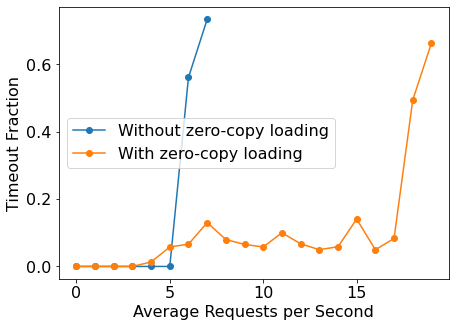

In [48]:
# Plot the two sets of results against each other.
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(7, 5))
plt.plot(baseline_stats.index, baseline_stats['timeout_fraction'],
         "-o", label='Without zero-copy loading')
plt.plot(zerocopy_stats.index, 
         zerocopy_stats['timeout_fraction'],
         "-o", label="With zero-copy loading")
plt.xlabel("Average Requests per Second")
plt.ylabel("Timeout Fraction")
plt.legend()